# Bài 2: GOOGLENET

In [2]:
%%writefile /kaggle/working/googlenet_model.py
import torch
import torch.nn as nn
import torchvision.models as models

def create_googlenet(num_classes: int = 10):
    """
    Tạo mô hình GoogLeNet và áp dụng các ràng buộc của đề bài.
    """
    
    model = models.googlenet(weights=None, num_classes=num_classes)
    model.conv1.conv = nn.Conv2d(
        3, 
        64, 
        kernel_size=(7, 7), 
        stride=(2, 2), 
        padding=(3, 3),  
        bias=False
    )

    for module in model.modules():
        if isinstance(module, nn.MaxPool2d):
            module.ceil_mode = True

    return model

if __name__ == "__main__":
    model = create_googlenet(num_classes=10)
    print("Cấu trúc mô hình GoogLeNet đã sửa đổi")
    print(f"Lớp Conv1: {model.conv1.conv}")
    print(f"Lớp MaxPool1: {model.maxpool1}")

Writing /kaggle/working/googlenet_model.py


In [3]:
%%writefile /kaggle/working/image_dataset.py
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from glob import glob

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Tìm tất cả các file ảnh
        self.image_paths = sorted(glob(os.path.join(root_dir, "*", "*.jpg")))
        self.image_paths.extend(sorted(glob(os.path.join(root_dir, "*", "*.png"))))
        self.image_paths.extend(sorted(glob(os.path.join(root_dir, "*", "*.jpeg"))))
        
        self.class_names = sorted([d for d in os.listdir(root_dir) 
                                   if os.path.isdir(os.path.join(root_dir, d))])
        
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        
        self.labels = []
        for img_path in self.image_paths:
            class_name = os.path.basename(os.path.dirname(img_path))
            self.labels.append(self.class_to_idx[class_name])

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> dict:
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return {"image": image, "label": torch.tensor(label, dtype=torch.long)}

# Hàm collate (gom batch)
def collate_fn(items: list[dict]) -> dict:
    images = [item["image"] for item in items]
    labels = [item["label"] for item in items]

    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    return {"image": images, "label": labels}

normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)

def get_train_transform():
    """
    Transform cho tập train: Bao gồm Augmentation
    """
    return transforms.Compose([
        transforms.Resize((256, 256)),      # resz
        transforms.RandomCrop((224, 224)),  
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize_transform
    ])

def get_test_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # resz
        transforms.ToTensor(),
        normalize_transform
    ])

Writing /kaggle/working/image_dataset.py


In [4]:
%%writefile /kaggle/working/train_googlenet.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import json
import os

from googlenet_model import create_googlenet
from image_dataset import ImageFolderDataset, collate_fn, get_train_transform, get_test_transform

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Đang sử dụng thiết bị: {device}")

os.makedirs("/kaggle/working/output", exist_ok=True)

def evaluate(dataloader: DataLoader, model: nn.Module) -> dict:
    model.eval()
    predictions, trues = [], []

    with torch.no_grad():
        for item in dataloader:
            image: torch.Tensor = item["image"].to(device)
            label: torch.Tensor = item["label"].to(device)

            output: torch.Tensor = model(image)
            if isinstance(output, tuple):
                output = output[0]
                
            output = torch.argmax(output, dim=1)
            predictions.extend(output.cpu().numpy())
            trues.extend(label.cpu().numpy())

    return {
        "precision": precision_score(trues, predictions, average="macro", zero_division=0),
        "recall": recall_score(trues, predictions, average="macro", zero_division=0),
        "accuracy": accuracy_score(trues, predictions),
        "f1": f1_score(trues, predictions, average="macro", zero_division=0)
    }

# Huan luyen
if __name__ == "__main__":
    
    TRAIN_DIR = "/kaggle/input/vinafood21/VinaFood21/train" 
    TEST_DIR = "/kaggle/input/vinafood21/VinaFood21/test"
    NUM_CLASSES = 21 
    EPOCH = 15
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    
    train_transform = get_train_transform()
    test_transform = get_test_transform()

    train_dataset = ImageFolderDataset(
        root_dir=TRAIN_DIR,
        transform=train_transform  
    )

    test_dataset = ImageFolderDataset(
        root_dir=TEST_DIR,
        transform=test_transform   
    )
    
    print(f"Tìm thấy {len(train_dataset)} ảnh train thuộc {NUM_CLASSES} lớp.")
    print(f"Tìm thấy {len(test_dataset)} ảnh test.")

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE * 2,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    model = create_googlenet(num_classes=NUM_CLASSES).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    loss_fn = nn.CrossEntropyLoss()

    best_score = 0
    best_metric = "f1"
    train_losses = []
    test_metrics = [] 

    for epoch in range(EPOCH):
        model.train()
        epoch_loss = 0.0

        for item in train_dataloader:
            image: torch.Tensor = item["image"].to(device)
            label: torch.Tensor = item["label"].to(device)

            optimizer.zero_grad()
            
            outputs = model(image)
            loss_main = loss_fn(outputs.logits, label)
            loss_aux1 = loss_fn(outputs.aux_logits1, label)
            loss_aux2 = loss_fn(outputs.aux_logits2, label)
            
            loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2

            loss.backward()
            optimizer.step()
            epoch_loss += loss_main.item()
        
        avg_loss = epoch_loss / len(train_dataloader)
        metrics = evaluate(test_dataloader, model)
        
        train_losses.append(avg_loss)
        test_metrics.append(metrics) # Lưu dict metrics

        print(f"Epoch [{epoch+1}/{EPOCH}] "
              f"Loss: {avg_loss:.4f} | "
              f"Acc: {metrics['accuracy']:.4f} | "
              f"Precision: {metrics['precision']:.4f} | "
              f"Recall: {metrics['recall']:.4f} | "
              f"F1: {metrics['f1']:.4f}")

        if metrics[best_metric] > best_score:
            best_score = metrics[best_metric]
            # luu model vao output
            torch.save(model.state_dict(), "/kaggle/working/output/best_googlenet_model.pth")
            print(f"Lưu mô hình tốt nhất tại epoch {epoch+1}")
            
    print("huan luyen xong-")
    
    history_data = {
        "train_losses": train_losses,
        "test_metrics": test_metrics 
    }
    
    # luu history
    with open("/kaggle/working/output/googlenet_history.json", "w") as f:
        json.dump(history_data, f)
        

Writing /kaggle/working/train_googlenet.py


In [5]:
!python /kaggle/working/train_googlenet.py

Đang sử dụng thiết bị: cuda
Tìm thấy 10044 ảnh train thuộc 21 lớp.
Tìm thấy 6682 ảnh test.
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch [1/15] Loss: 2.7744 | Acc: 0.1651 | Precision: 0.1060 | Recall: 0.1288 | F1: 0.0940
Lưu mô hình tốt nhất tại epoch 1
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch [2/15] Loss: 2.5141 | Acc: 0.2029 | Precision: 0.2151 | Recall: 0.1633 | F1: 0.1251
Lư

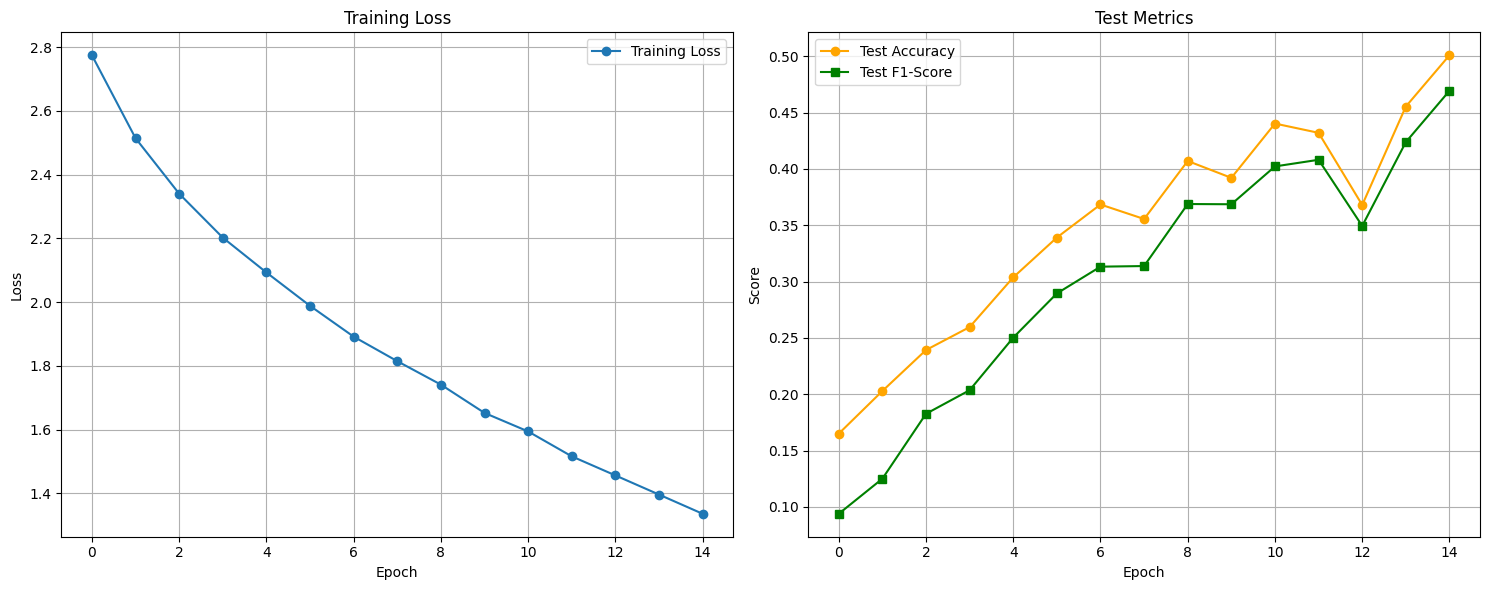

In [6]:
import json
import matplotlib.pyplot as plt

history_path = "/kaggle/working/output/googlenet_history.json"

try:
    with open(history_path, "r") as f:
        history = json.load(f)

    train_losses = history["train_losses"]
    
    test_metrics = history["test_metrics"]
    test_accuracies = [m['accuracy'] for m in test_metrics]
    test_f1s = [m['f1'] for m in test_metrics]

    # Vẽ 2 biểu đồ
    plt.figure(figsize=(15, 6))
    
    # Biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o', label='Training Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Biểu đồ metrics
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, marker='o', color='orange', label='Test Accuracy')
    plt.plot(test_f1s, marker='s', color='green', label='Test F1-Score')
    plt.title("Test Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Không tìm thấy file {history_path}")